<h1 style="color:rgb(17, 116, 155);text-align:left;font-size:250%;font-family:verdana;text-decoration:underline;"> 
    Advanced topics - Final Project - Part 2: Image Retrieval</h1>

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import tensorflow as tf
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import faiss
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
#  **שלב 1: טעינת הנתונים (TFRecord) והכנה לפורמט PyTorch**
print(" Loading Cars196 dataset from TFRecord files...")

data_dir = r"C:\Users\revit\Documents\Data Learning\cars196"

#  יצירת רשימת קבצי ה-TFRecord
train_files = [os.path.join(data_dir, f"cars196-train.tfrecord-0000{i}-of-00008") for i in range(8)]
test_files = [os.path.join(data_dir, f"cars196-test.tfrecord-0000{i}-of-00008") for i in range(8)]

#  פונקציה לקריאת TFRecord
# מגדיר אילו תכונות קיימות בכל דוגמה: תמונה (בפורמט מחרוזת) ותווית (int64).
def parse_tfrecord(example):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }
    # מפענח את הדוגמה בהתאם למאפיינים שהוגדרו.
    parsed_example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(parsed_example['image'], channels=3)
    image = tf.image.resize(image, (224, 224)) # משנה את גודל התמונה לגודל 224x224 שמתאים ל-ResNet50.
    label = parsed_example['label']
    return image, label # מחזיר את התמונה והתווית.

# פונקציה שקוראת קבצים וממפה כל דוגמה לפורמט של (תמונה, תווית), ואז מחזירה רשימה.
def load_tfrecord_dataset(filenames):
    raw_dataset = tf.data.TFRecordDataset(filenames)
    dataset = raw_dataset.map(parse_tfrecord)
    return list(dataset)  # ממירים לרשימה לשימוש ב-PyTorch

#  טעינת ה-Train/Test מ-TFRecord
# ממירים את כל התמונות לפורמט NumPy בגודל מתאים, כדי להשתמש בהן עם PyTorch בהמשך.
train_data = [(image.numpy().astype('uint8'), label.numpy()) for image, label in load_tfrecord_dataset(train_files)]
test_data = [(image.numpy().astype('uint8'), label.numpy()) for image, label in load_tfrecord_dataset(test_files)]

print(f" Loaded {len(train_data)} training images and {len(test_data)} test images.")


🔹 Loading Cars196 dataset from TFRecord files...
✅ Loaded 8144 training images and 8041 test images.


In [4]:
#  **שלב 2: יצירת מחלקת Dataset מותאמת ל-PyTorch**
class Cars196Dataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform # מגדיר מחלקה שמרחיבה את Dataset של PyTorch. מקבלת דאטה (רשימת תמונות) וטרנספורמציות.

    def __len__(self):
        return len(self.data) # מחזירה את כמות הדוגמאות.

    def __getitem__(self, idx):
        image_np, label = self.data[idx]
        image = Image.fromarray(image_np)
        if self.transform:
            image = self.transform(image)
        return image, label # מחזירה את הדוגמה לפי אינדקס, כולל טרנספורמציה אם הוגדרה.

In [5]:
#  **שלב 3: הגדרת טרנספורמציות לנתונים**
print("🔹 Applying transformations to the dataset...")

# מתחילים לבנות רצף של טרנספורמציות שמופעלות על כל תמונה בסט האימון.
train_transform = transforms.Compose([ 
    transforms.RandomHorizontalFlip(),    # הופך את התמונה באופן אקראי מצד ימין לשמאל (כמו מראה).
    transforms.RandomRotation(10),     # מסובב את התמונה בזווית אקראית בין -10° ל-10°.
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),    # חותך חלק אקראי מהתמונה (בין 80% ל-100% מהשטח), ואז משנה לגודל 224×224.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),     # משנה בהגרלה את הבהירות, ניגודיות, רוויה צבעונית , גוונים
    transforms.ToTensor(),    # ממיר את התמונה מפורמט PIL (או numpy) לטנזור של PyTorch.
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])    # מנרמל כל ערוץ צבע (R, G, B) לפי ממוצעים וסטיות תקן של ImageNet.
# לוודא שהתמונות תואמות למה שהמודל המאומן על ImageNet מצפה לקבל.

])
# מגדיר רצף של פעולות לעיבוד תמונה באימון: פליפ, סיבוב, חיתוך, התאמות צבעים, והמרה ל-Tensor.

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# עבור הבדיקה עושים רק המרה ל-Tensor ונירמול (ללא אוגמנטציה).
#המטרה לבדוק את המודל בתנאים "נקיים" כמו תמונות אמיתיות בעולם האמיתי.

🔹 Applying transformations to the dataset...


In [6]:
#  **שלב 4: יצירת DataLoaders**
batch_size = 32    # בכל שלב אימון, נטענות 32 תמונות + תוויות.

# יוצרים את הדאטאסטים שלך (Dataset) ל-Train ו-Test.
# כל אחד מהם יודע להחזיר תמונה ותיוג לפי אינדקס, עם הטרנספורמציות
train_dataset = Cars196Dataset(train_data, transform=train_transform)
test_dataset = Cars196Dataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
# shuffle=True – מערבב את הנתונים בכל epoch (מאוד חשוב למנוע הטיות באימון).

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# בלי shuffle – כי בזמן בדיקה רוצים עקביות ולא ערבוב.
# num_workers=0 – קובע כמה תהליכים (processes) יטענו במקביל את הדאטה.

print(f" Train and Test Dataloaders created with batch size {batch_size}.")


✅ Train and Test Dataloaders created with batch size 32.


In [7]:
#  **שלב 5: טעינת מודל ResNet50 עם התאמות**
print("🔹 Initializing ResNet50 model...")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # טוען את המודל ResNet50 עם משקלים מאומנים מראש על ImageNet
num_features = model.fc.in_features # חילוץ מספר הפיצ'רים מהשכבה האחרונה לפני הסיווג
# בודקים כמה פיצ'רים יוצאים מה־ResNet (זה in_features של fc).ואז משתמשים במספר הזה כדי לבנות שכבת Linear חדשה משלנו

#  דימוי פשוט: הרשת היא פס ייצור, כל תמונה יוצאת ממנו עם 2048 מאפיינים,
# עכשיו רוצים להחליט לאיזו מחלקה (class) היא שייכת.
# אז בונים שלב אחרון חדש בפס הייצור, שמתאים ל־2048 כניסות ו־196 יציאות (מספר הקטגוריות שלנו).

#החלפת שכבת הסיווג
model.fc = nn.Sequential(
    nn.Dropout(0.5),   # מכבה 50% מהנוירונים באימון (באקראי) – כדי למנוע Overfitting.
    nn.Linear(num_features, len(set(label for _, label in train_data)))  
# Linear() - יוצר שכבה חדשה שממפה מ־2048 פיצ'רים (או כמה שיש) ל־196 מחלקות, שזה מספר הקטגוריות של רכבים ב־Cars196.
# len() - מחשב את מספר הקטגוריות הייחודיות (labels שונים) ב־Train Set.
)
model = model.to(device)

print(" Model initialized and moved to", device)

🔹 Initializing ResNet50 model...
✅ Model initialized and moved to cpu


In [8]:
#  **שלב 6: פונקציית הפסד ואופטימיזציה**
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4) # האופטימייזר אחראי לעדכן את המשקלים של המודל לפי הגרדיאנטים שחושבו.
# model.parameters()-	כל המשקלים שצריך לעדכן במודל.
# Learning Rate – כמה לשנות כל פעם את המשקלים (קצב הלמידה).
# momentum=0.9-	עוזר להתגבר על רעש ולקבל עדכונים יציבים יותר – זוכר את הכיוון של הצעד הקודם.
# weight_decay-	סוג של רגולריזציה – עוזר להימנע מ-overfitting על ידי "עונש" על משקלים גדולים מדי.

In [9]:
import gc
import torch

torch.cuda.empty_cache()  # אם יש GPU (לא אצלך)
gc.collect()  # ניקוי זיכרון בפייתון
# משחררים זיכרון לא נחוץ

377

In [10]:
#  **שלב 7: אימון הרשת עם Early Stopping**
print("🔹 Starting model training...")

num_epochs = 10
best_test_acc = 0.0
patience = 3
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    print(f" Epoch {epoch+1}/{num_epochs} started.")  

    for batch_idx, (images, labels) in enumerate(train_loader):
        print(f"Processing Batch {batch_idx}/{len(train_loader)}...")  # הדפסת סטטוס

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # איפוס גרדיאנטים
        outputs = model(images)   # פלט המודל
        loss = criterion(outputs, labels)  # חישוב הפסד
        loss.backward()  # חישוב גרדיאנטים
        optimizer.step()   # עדכון המשקלים

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # בוחר את המחלקה עם ההסתברות הגבוהה ביותר מתוך הפלטים של המודל.
        correct += (predicted == labels).sum().item()  # סופר כמה ניחושים היו נכונים.
        total += labels.size(0)

        if batch_idx % 10 == 0:
            print(f" Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")

    #  שמירת Checkpoint כל 50 באצ'ים
    if batch_idx % 50 == 0 and batch_idx > 0:  
        torch.save(model.state_dict(), f"checkpoint_epoch_{epoch+1}_batch_{batch_idx}.pth")
        print(f" Model checkpoint saved at epoch {epoch+1}, batch {batch_idx}")
    
    train_accuracy = correct / total  # מחשב דיוק כולל ל־Train Set.
    print(f"\n Epoch {epoch+1}/{num_epochs} Completed!")
    print(f"🔹 Average Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

#  שלב 8: בדיקת דיוק על ה-Test אחרי כל epoch
    print("🔹 Evaluating on Test Set...")
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():  # בדיקה בלי גרדיאנטים כי לא מאמנים עכשיו.
        for images, labels in test_loader:
            print(f"🔹 Evaluating Batch {batch_idx}/{len(test_loader)}...")  # הדפסת סטטוס
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    test_accuracy = correct / total
    print(f" Test Accuracy after epoch {epoch+1}: {test_accuracy:.4f}")

    #  Early Stopping
    if test_accuracy > best_test_acc:
        best_test_acc = test_accuracy
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(" Best model saved!")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(" Early stopping triggered. Training stopped.")
            break

print(" Training Completed!")

🔹 Starting model training...
✅ Epoch 1/10 started.
Processing Batch 0/255...
✅ Epoch 1/10, Batch 0/255, Loss: 5.3063
Processing Batch 1/255...
Processing Batch 2/255...
Processing Batch 3/255...
Processing Batch 4/255...
Processing Batch 5/255...
Processing Batch 6/255...
Processing Batch 7/255...
Processing Batch 8/255...
Processing Batch 9/255...
Processing Batch 10/255...
✅ Epoch 1/10, Batch 10/255, Loss: 5.3023
Processing Batch 11/255...
Processing Batch 12/255...
Processing Batch 13/255...
Processing Batch 14/255...
Processing Batch 15/255...
Processing Batch 16/255...
Processing Batch 17/255...
Processing Batch 18/255...
Processing Batch 19/255...
Processing Batch 20/255...
✅ Epoch 1/10, Batch 20/255, Loss: 5.3132
Processing Batch 21/255...
Processing Batch 22/255...
Processing Batch 23/255...
Processing Batch 24/255...
Processing Batch 25/255...
Processing Batch 26/255...
Processing Batch 27/255...
Processing Batch 28/255...
Processing Batch 29/255...
Processing Batch 30/255...


In [36]:
#  **טעינת המודל המאומן**
model_path = r"C:\Users\revit\Documents\Data Learning\Project2\best_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # טוען את מודל ResNet50 עם משקלים טרום-מאומנים מ־ImageNet.
# שמרנו רק את המשקלים של המודל אבל לא שמרנו את המבנה של המודל עצמו ולכן צריך לבנות את המחודש מחדש כדי שפייטורץ' ידע איפה לשים את המשקלים

num_features = model.fc.in_features  #  בודק כמה פיצ'רים מגיעים מה־ResNet לפני שלב הסיווג (בדרך כלל 2048).

# מחליפים את שכבת הסיווג (FC) המקורית של ImageNet בחדשה שמתאימה ל־196 קטגוריות (Cars196).
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_features, 196)  # 196 מחלקות עבור Cars196
)

model.load_state_dict(torch.load(model_path, map_location=device))
# טוען את המשקלים ששמרנו בקובץ best_model.pth וממקם אותם במודל.
model = model.to(device)

model.eval() # מגדיר את המודל למצב הערכה (evaluation) — חשוב כדי לכבות Dropout ו־BatchNorm, ולהבטיח יציבות בפלטים (כמו שלמדנו מקודם).
# אם לא נעביר את המודל למצב eval(), הוא יתנהג כאילו עדיין מאמנים אותו – ויחזיר אמבדינגס שלא עקביים בכל פעם שנריץ את אותה תמונה!

# **הפיכת המודל ל-Feature Extractor**
# Feature Extractor- המרת תמונה לווקטור תכונות מספרי שמייצג את תוכנה (צורה, צבע, טקסטורה).
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
# מחלצים את כל המודל חוץ משכבת הסיווג האחרונה — כלומר את כל החלק שמפיק וקטור תכונות (embedding) לכל תמונה.
# במקום שהמודל יחזיר Label כמו "BMW X3",הוא יחזיר וקטור באורך 2048 (או כמה שה־ResNet מוציא) שמתאר את המראה של התמונה.

print(" המודל נטען בהצלחה כ-Feature Extractor!")

✅ המודל נטען בהצלחה כ-Feature Extractor!


C:\Users\revit\AppData\Local\Temp\ipykernel_11092\794478536.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=de

In [24]:
#  הוצאת התכונות (Features) מכל התמונות
# נשתמש במודל המאומן כדי לחלץ וקטורי תכונות (Embeddings) מכל התמונות במאגר.

In [37]:
#  **הגדרת טרנספורמציות**
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#  **טעינת הנתונים ויצירת FAISS Index**
image_embeddings = []  # עבור הפיצ'רים
image_labels = []   # עבור התוויות

if len(train_data) == 0:
    raise ValueError(" שגיאה: לא נמצאו תמונות ב-Train Set! בדוק את הנתונים שלך.")

print("🔹 טעינת התמונות ל-FAISS...")

with torch.no_grad():  # לא מחשבים גרדיאנטים כילא מאמנים אלא רק מריצים
    for idx, (image_np, label) in enumerate(train_data):  # עוברת על כל התמונות והתוויות ב־Train Set. 
        image = Image.fromarray(image_np)
        image = transform(image).unsqueeze(0).to(device)

        # שומר את התכונה והתווית ברשימות
        embedding = feature_extractor(image).squeeze().cpu().numpy()  # מריץ את התמונה דרך המודל ללא שכבת הסיווג
        embedding = embedding.flatten()   # מוודא שהווקטור הוא מישור
        
        image_embeddings.append(embedding)
        image_labels.append(label)
        
        if idx % 500 == 0:
            print(f"🔹 עיבוד תמונה {idx}: label = {label}")

#  **בניית אינדקס FAISS** 
features_array = np.array(image_embeddings, dtype="float32")   # ממיר את רשימת הווקטורים למערך אחד בגודל [מספר תמונות, 2048]
d = features_array.shape[1]  # מאחסן את אורך כל וקטור
index = faiss.IndexFlatL2(d)  # יוצר אינדקס FAISS שמשתמש במרחק אוקלידי (L2) כדי למדוד דמיון בין התמונות.
index.add(features_array)   # מוסיף את כל הווקטורים לאינדקס — מכאן ואילך אפשר יהיה לחפש בהם.

print(f" FAISS נבנה בהצלחה! {index.ntotal} תמונות נוספו.")


🔹 טעינת התמונות ל-FAISS...
🔹 עיבוד תמונה 0: label = 194
🔹 עיבוד תמונה 500: label = 169
🔹 עיבוד תמונה 1000: label = 98
🔹 עיבוד תמונה 1500: label = 55
🔹 עיבוד תמונה 2000: label = 89
🔹 עיבוד תמונה 2500: label = 4
🔹 עיבוד תמונה 3000: label = 135
🔹 עיבוד תמונה 3500: label = 87
🔹 עיבוד תמונה 4000: label = 55
🔹 עיבוד תמונה 4500: label = 79
🔹 עיבוד תמונה 5000: label = 130
🔹 עיבוד תמונה 5500: label = 97
🔹 עיבוד תמונה 6000: label = 24
🔹 עיבוד תמונה 6500: label = 163
🔹 עיבוד תמונה 7000: label = 62
🔹 עיבוד תמונה 7500: label = 128
🔹 עיבוד תמונה 8000: label = 189
✅ FAISS נבנה בהצלחה! 8144 תמונות נוספו.


In [26]:
# חיפוש תמונות דומות לתמונה נתונה
# נגדיר פונקציה שמקבלת נתיב של תמונה חדשה ומחזירה את התמונות הכי דומות לה.

In [38]:
#  **פונקציה למציאת תמונות דומות**
def search_similar_images(query_image_np, top_k=5):
    query_image = Image.fromarray(query_image_np)  # המרת תמונה ל נאמפיי
    query_image = transform(query_image).unsqueeze(0).to(device)

    with torch.no_grad():  # לא לחשב גרדיאנטים כי אנחנו מבצעים בדיקה
        query_embedding = feature_extractor(query_image).squeeze().cpu().numpy()  
        # מעביר את תמונת השאילתה דרך המודל ללא שכבת הסיווג (כלומר, feature extractor בלבד) כדי לקבל את וקטור התכונות של התמונה.
        
        query_embedding = query_embedding.flatten().astype("float32") # מוודא שהווקטור חד-ממדי ומטיפוס float32

    D, I = index.search(np.expand_dims(query_embedding, axis=0), top_k)
    #חפש את top_k התמונות הכי דומות לתמונת השאילתה
    return I[0], D[0] # מחזיר רשימת האינדקסים של התמונות הכי דומות והמרחקים שלהן

#  **בדיקה עם תמונה מה-Test Set**
query_image_np, _ = test_data[0]  # תמונה ראשונה מתוך סט הבדירה
similar_indices, distances = search_similar_images(query_image_np, top_k=5)  # ומחפש את 5 הדומות

print("🔹 נמצאו התמונות הבאות:")
for i, idx in enumerate(similar_indices):
    print(f"{i+1}. תמונה עם label {image_labels[idx]} (מרחק: {distances[i]:.4f})")


🔹 נמצאו התמונות הבאות:
1. תמונה עם label 141 (מרחק: 328.9936)
2. תמונה עם label 141 (מרחק: 392.0753)
3. תמונה עם label 141 (מרחק: 447.1921)
4. תמונה עם label 169 (מרחק: 453.8419)
5. תמונה עם label 141 (מרחק: 475.6418)


In [28]:
# הצגת תמונות דומות

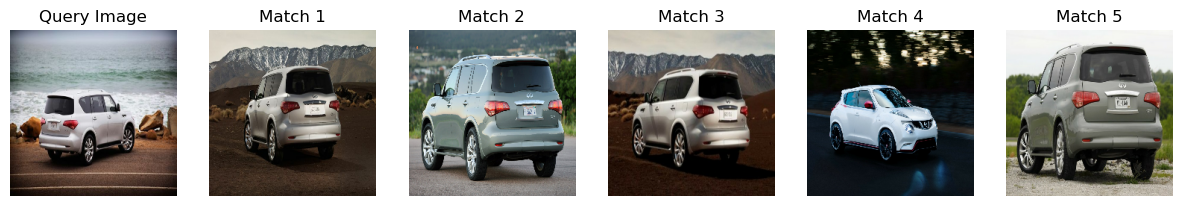

In [29]:
#  **פונקציה להצגת תמונות דומות**
def display_similar_images(query_image_np, similar_indices):
    fig, axes = plt.subplots(1, len(similar_indices) + 1, figsize=(15, 5))
    axes[0].imshow(query_image_np)
    axes[0].set_title("Query Image")
    axes[0].axis("off")
    
    for i, idx in enumerate(similar_indices):
        similar_image_np, _ = train_data[idx]
        axes[i + 1].imshow(similar_image_np)
        axes[i + 1].set_title(f"Match {i+1}")
        axes[i + 1].axis("off")
    
    plt.show()

#  **בדיקה: חיפוש והצגת תמונות דומות**
query_image_np, _ = test_data[0]
similar_indices, _ = search_similar_images(query_image_np, top_k=5)
display_similar_images(query_image_np, similar_indices)


In [30]:
# הערכת איכות המערכת

In [31]:
#  **הערכת הדיוק של חיפוש התמונות**
correct_matches = 0
total_queries = len(test_data)

for i in range(total_queries):
    query_image_np, true_label = test_data[i]  #  שולף את התמונה והתיוג האמיתי שלה מתוך ה-Test Set.
    similar_indices, _ = search_similar_images(query_image_np, top_k=5)  # 5 הכי דומות
    retrieved_labels = [image_labels[idx] for idx in similar_indices]  # שולף תוויות של התמונות
    
    if true_label in retrieved_labels:  # בודק אם אחת מהתמונות שנמצאו באמת שייכת לאותו label כמו תמונת השאילתה.
        correct_matches += 1

accuracy = correct_matches / total_queries
#מחלק את מספר ההתאמות הנכונות במספר כלל השאילתות כדי לחשב את דיוק השליפה – בין 0 ל־1.
print(f" דיוק המערכת (Retrieval Accuracy): {accuracy:.4f}")


✅ דיוק המערכת (Retrieval Accuracy): 0.8710


# איך לבדוק אם החיפוש באמת עובד?

🔹 תמונת השאילתה היא מהרכב עם התווית: 65


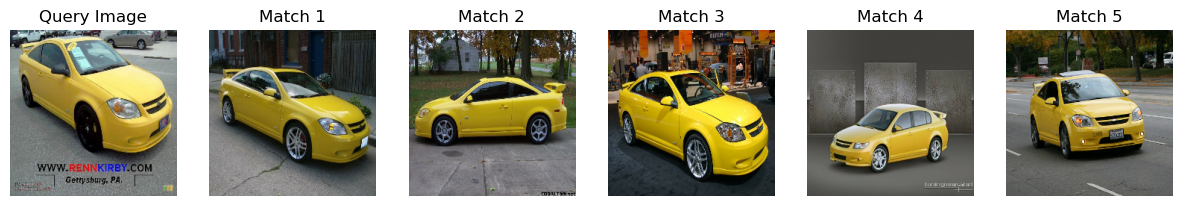

🔹 נמצאו התמונות הדומות הבאות:
1. תמונה עם label 65 (מרחק: 336.5162)
2. תמונה עם label 65 (מרחק: 391.0938)
3. תמונה עם label 65 (מרחק: 391.1129)
4. תמונה עם label 65 (מרחק: 440.2368)
5. תמונה עם label 65 (מרחק: 485.5797)


In [32]:
import numpy as np

#  בחירת תמונה אקראית מתוך ה-Test Set
query_index = np.random.randint(len(test_data))  # בחירה רנדומלית של תמונה
query_image_np, true_label = test_data[query_index]  # טעינת התמונה והתיוג שלה

# 🔍 חיפוש תמונות דומות
similar_indices, distances = search_similar_images(query_image_np, top_k=5)

# 📸 הצגת התמונה המקורית והתמונות הדומות
print(f"🔹 תמונת השאילתה היא מהרכב עם התווית: {true_label}")
display_similar_images(query_image_np, similar_indices)

#  הדפסת התוצאות עם המרחקים מהתמונות הדומות שנמצאו
print("🔹 נמצאו התמונות הדומות הבאות:")
for i, idx in enumerate(similar_indices):
    print(f"{i+1}. תמונה עם label {image_labels[idx]} (מרחק: {distances[i]:.4f})")


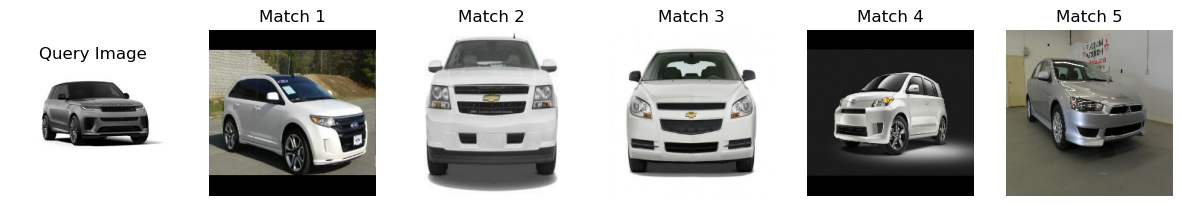

🔹 נמצאו התמונות הבאות:
1. תמונה עם label 109 (מרחק: 573.6252)
2. תמונה עם label 61 (מרחק: 579.0670)
3. תמונה עם label 66 (מרחק: 600.4886)
4. תמונה עם label 177 (מרחק: 604.5338)
5. תמונה עם label 166 (מרחק: 605.5303)


In [34]:
#  **טעינת תמונה חיצונית וביצוע חיפוש**
external_image_path = r"C:\Users\revit\Documents\Data Learning\Project2\range_rover.jpeg"  # עדכון בהתאם לסיומת

# קריאת התמונה החיצונית
external_image = Image.open(external_image_path).convert("RGB")
external_image_np = np.array(external_image)

# חיפוש תמונות דומות
similar_indices, distances = search_similar_images(external_image_np, top_k=5)

# הצגת התוצאות
display_similar_images(external_image_np, similar_indices)

print("🔹 נמצאו התמונות הבאות:")
for i, idx in enumerate(similar_indices):
    print(f"{i+1}. תמונה עם label {image_labels[idx]} (מרחק: {distances[i]:.4f})")


In [ ]:
# בדיקה על 3 תמונות 

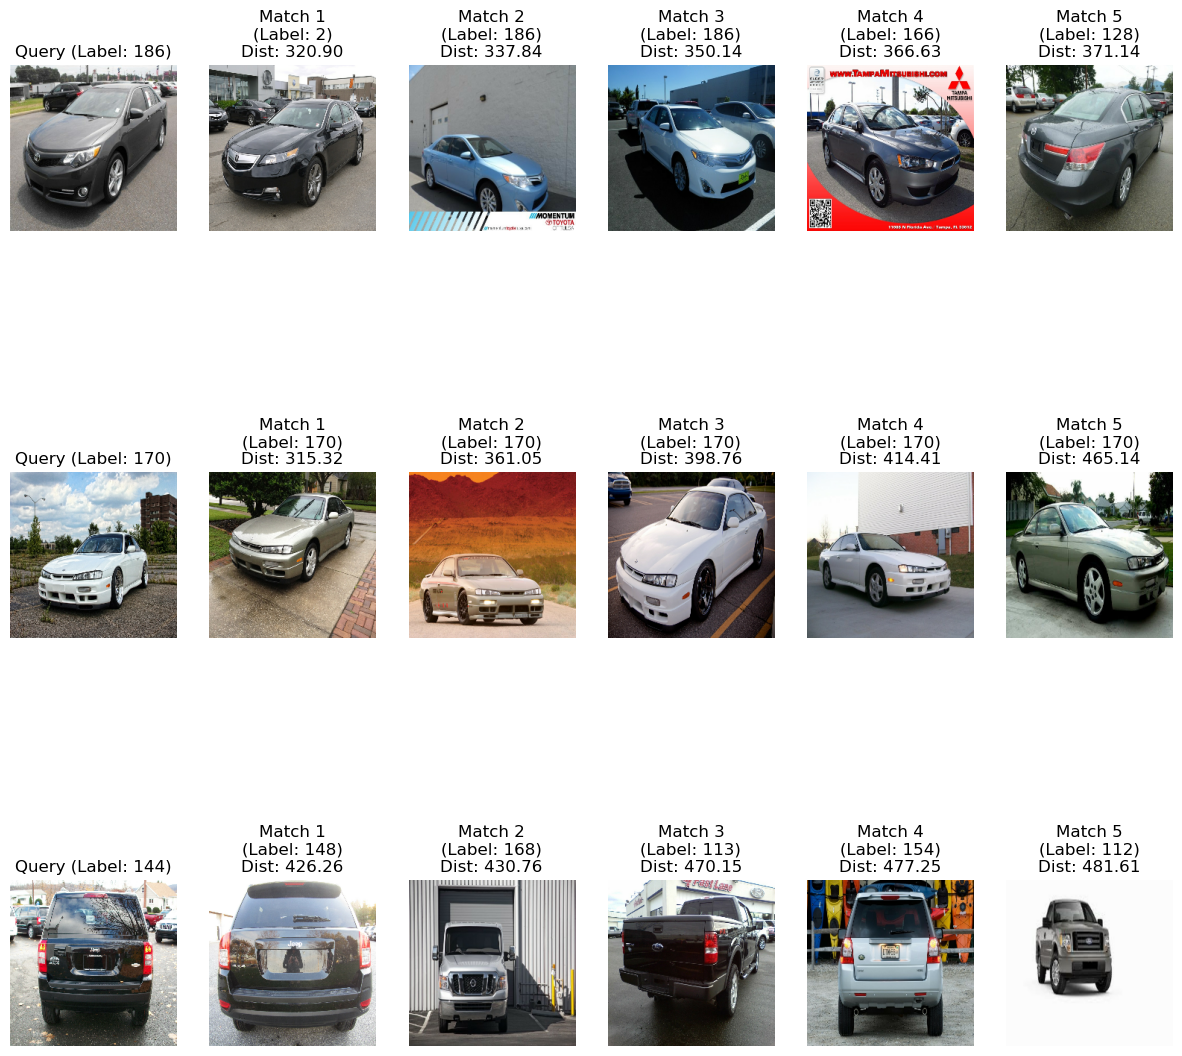

In [40]:
import random

#  **פונקציה להצגת מספר תמונות שאילתא עם התמונות הדומות להן**
def display_multiple_queries(test_data, num_queries=3, top_k=5):
    """
    מציגה num_queries תמונות מתוך ה-Test Set יחד עם התמונות הדומות להן.
    """
    # בחירת num_queries תמונות אקראיות מתוך ה-Test Set
    query_samples = random.sample(test_data, num_queries)
    
    fig, axes = plt.subplots(num_queries, top_k + 1, figsize=(15, 5 * num_queries))

    for row, (query_image_np, true_label) in enumerate(query_samples):
        similar_indices, distances = search_similar_images(query_image_np, top_k=top_k)

        # הצגת התמונה המקורית
        axes[row, 0].imshow(query_image_np)
        axes[row, 0].set_title(f"Query (Label: {true_label})")
        axes[row, 0].axis("off")

        # הצגת התמונות הדומות
        for col, idx in enumerate(similar_indices):
            similar_image_np, retrieved_label = train_data[idx]
            axes[row, col + 1].imshow(similar_image_np)
            axes[row, col + 1].set_title(f"Match {col+1}\n(Label: {retrieved_label})\nDist: {distances[col]:.2f}")
            axes[row, col + 1].axis("off")

    plt.show()

# **בדיקה: הצגת 3 תמונות שאילתא עם 5 ההתאמות הדומות ביותר**
display_multiple_queries(test_data, num_queries=3, top_k=5)


In [ ]:
# הערכת דיוק

In [41]:
#  **הערכת הדיוק של חיפוש התמונות**
correct_matches = 0
total_queries = len(test_data)

for i in range(total_queries):
    query_image_np, true_label = test_data[i]
    similar_indices, _ = search_similar_images(query_image_np, top_k=5)
    retrieved_labels = [image_labels[idx] for idx in similar_indices]
    
    if true_label in retrieved_labels:
        correct_matches += 1

accuracy = correct_matches / total_queries
print(f" דיוק המערכת (Retrieval Accuracy): {accuracy:.4f}")

✅ דיוק המערכת (Retrieval Accuracy): 0.8710
